# Financial Economics PS 6
## Maximilian Huber
This code is stored at https://github.com/MaximilianJHuber/NYU/blob/master/FinEcon%201/PS6.ipynb

## 2
We solve the PDE
$$0=-r\,g(Q,t) + g_t(Q,t) + g_Q(Q,t)\,r\,Q + \frac{1}{2}g_{QQ}(Q,t)\,\sigma^2\,Q^2$$

by replacing the derivatives with finite differences on a grid $i, j \in [Q_0, Q_I] \times [t_0,t_J]$. Using forward differentiation in the time direction is particularily convenient, because the resulting linear system of equations is small.

In [2]:
using Parameters
using Plots; pyplot()
using Distributions

@with_kw mutable struct BS
    T            # t ∈ [0, T]
    J            # t ∈ [t0, tJ]
    Δt           # step size
    Tgrid        # J + 1 grid

    Q0           # lower bound
    QI           # upper bound
    I            # Q ∈ [Q0, QI]
    Qgrid        # I + 1 grid

    σ
    r
    K
end

function BS(; T = 1., J = 500, Q0 = 50, QI = 150, I = 300, σ = 0.16, r = 0.01, K = 100.)
    BS(T, J, T/J, linspace(0,T,J+1), Q0, QI, I, linspace(Q0, QI, I+1), σ, r, K)
end

function call(model::BS, Q)
    max.(Q .- model.K, 0)
end

call (generic function with 1 method)

The general scheme is FTBS, forward time backward space, :

$$0=-r\,g(i,j) + \frac{g(i,j+1) - g(i,j)}{\Delta t} + \frac{g(i,j)-g(i-1,j)}{Q_{i}-Q_{i-1}}\,r\,Q_i + \frac{1}{2}\frac{1}{Q_{i+1}-Q_i}\Big[\frac{g(i+1,j)-g(i,j)}{Q_{i+1}-Q_i} - \frac{g(i,j)-g(i-1,j)}{Q_{i}-Q_{i-1}}\Big]\,\sigma^2\,Q_i^2$$

For interior $i$:

$$g(i,j)\Big(r + \frac{1}{\Delta t} - \frac{r\,Q_i}{Q_{i}-Q_{i-1}} + \frac{1}{2}\frac{1}{Q_{i+1}-Q_i}\frac{\sigma^2\,Q_i^2}{Q_{i+1}-Q_i} + \frac{1}{2}\frac{1}{Q_{i+1}-Q_i}\frac{\sigma^2\,Q_i^2}{Q_{i}-Q_{i-1}}\Big) + g(i-1,j)\Big(\frac{r\,Q_i}{Q_{i}-Q_{i-1}} - \frac{1}{2}\frac{1}{Q_{i+1}-Q_i}\frac{\sigma^2\,Q_i^2}{Q_{i}-Q_{i-1}}\Big) + g(i+1,j)\frac{-1}{2}\frac{1}{Q_{i+1}-Q_i}\frac{\sigma^2\,Q_i^2}{Q_{i+1}-Q_i} = \frac{g(i,j+1)}{\Delta t}$$

and for $i=0$ we must do forward differences and replace $g_{QQ}(0,j)$ with $g_{QQ}(1,j)$:

$$g(0,j)\Big(r + \frac{1}{\Delta t} + \frac{r\,Q_0}{Q_{1}-Q_{0}} - \frac{1}{2}\frac{1}{Q_2-Q_1}\frac{\sigma^2\,Q_0^2}{Q_1-Q_0}\Big) + g(1,j)\Big(\frac{- r\,Q_0}{Q_{1}-Q_{0}} + \frac{1}{2}\frac{1}{Q_2-Q_1}\frac{\sigma^2\,Q_0^2}{Q_2-Q_1} + \frac{1}{2}\frac{1}{Q_2-Q_1}\frac{\sigma^2\,Q_0^2}{Q_1-Q_0}\Big) + g(2,j)\frac{-1}{2}\frac{1}{Q_2-Q_1}\frac{\sigma^2\,Q_0^2}{Q_2-Q_1}= \frac{g(0,j+1)}{\Delta t}$$

and for $i=I$ we replace $g_{QQ}(I,j)$ with $g_{QQ}(I-1,j)$:

$$g(I,j)\Big(r + \frac{1}{\Delta t} - \frac{r\,Q_I}{Q_{I}-Q_{I-1}} - \frac{1}{2}\frac{1}{Q_{I}-Q_{I-1}}\frac{\sigma^2\,Q_{I}^2}{Q_{I}-Q_{I-1}}\Big) + g(I-1,j)\Big(\frac{r\,Q_I}{Q_{I}-Q_{I-1}} + \frac{1}{2}\frac{1}{Q_{I}-Q_{I-1}}\frac{\sigma^2\,Q_{I}^2}{Q_{I}-Q_{I-1}} + \frac{1}{2}\frac{1}{Q_{I}-Q_{I-1}}\frac{\sigma^2\,Q_{I}^2}{Q_{I-1}-Q_{I-2}}\Big) + g(I-2,j)\frac{-1}{2}\frac{1}{Q_{I}-Q_{I-1}}\frac{\sigma^2\,Q_{I}^2}{Q_{I-1}-Q_{I-2}} = \frac{g(I,j+1)}{\Delta t}$$

In [3]:
function solve_BS_FTBS(model::BS, G)
    @unpack T, J, Δt, Tgrid, Q0, QI, I, Qgrid, σ, r, K = model
    g = zeros(I+1, J+1)
    g[:, J+1] = G(model, Qgrid)

    for j in J:-1:1
        A = spzeros(I+1, I+1)

        A[1, 1:3] = [r + 1/Δt + (r * Qgrid[1])/(Qgrid[2] - Qgrid[1]) - 
                    1/2 * 1 / (Qgrid[3] - Qgrid[2]) * (σ^2 * Qgrid[1]^2) / (Qgrid[2] - Qgrid[1]), 
                    (-r * Qgrid[1]) / (Qgrid[2] - Qgrid[1]) + 1/2 * (σ^2 * Qgrid[1]^2) / (Qgrid[3] - Qgrid[2])^2 + 
                    1/2 * 1 / (Qgrid[3] - Qgrid[2]) * (σ^2 * Qgrid[1]^2) / (Qgrid[2] - Qgrid[1]),
                    -1/2 * 1 / (Qgrid[3] - Qgrid[2]) * (σ^2 * Qgrid[1]^2) / (Qgrid[3] - Qgrid[2])]

        for i = 2:I
            A[i, (i-1):(i+1)] = [(r * Qgrid[i]) / (Qgrid[i] - Qgrid[i-1]) - 
                                1/2 * 1 / (Qgrid[i+1] - Qgrid[i]) * (σ^2 * Qgrid[i]^2) / (Qgrid[i] - Qgrid[i-1]),
                                r + 1/Δt - (r * Qgrid[i]) / (Qgrid[i] - Qgrid[i-1]) + 
                                1/2 * (σ^2 * Qgrid[i]^2) / (Qgrid[i+1] - Qgrid[i])^2 + 
                                1/2 * 1 / (Qgrid[i+1] - Qgrid[i]) * (σ^2 * Qgrid[i]^2) / (Qgrid[i] - Qgrid[i-1]),
                                -1/2 * 1 / (Qgrid[i+1] - Qgrid[i]) * (σ^2 * Qgrid[i]^2) / (Qgrid[i+1] - Qgrid[i])]
        end

        A[I+1, (I-1):(I+1)] = [-1/2 * 1 / (Qgrid[I+1] - Qgrid[I]) * (σ^2 * Qgrid[I+1]^2) / (Qgrid[I] - Qgrid[I-1]),
                              (r * Qgrid[I+1]) / (Qgrid[I+1] - Qgrid[I]) + 
                              1/2 * 1 / (Qgrid[I+1] - Qgrid[I]) * (r * Qgrid[I+1]^2) / (Qgrid[I+1] - Qgrid[I]) + 
                              1/2 * 1 / (Qgrid[I+1] - Qgrid[I]) * (r * Qgrid[I+1]^2) / (Qgrid[I] - Qgrid[I-1]),
                              r + 1/Δt - (r * Qgrid[I+1]) / (Qgrid[I+1] - Qgrid[I]) - 
                              1/2 * 1 / (Qgrid[I+1] - Qgrid[I]) * (σ^2 * Qgrid[I+1]^2) / (Qgrid[I+1] - Qgrid[I])]

        g[:, j] = (A \ (g[:, j+1] ./ Δt))
    end
    
    return g[:,1]
end

function BS_price_europeans(model::BS, Q)
    @unpack T, J, Δt, Tgrid, Q0, QI, I, Qgrid, σ, r, K = model
    z1 = (log(Q/K) + (r + 1/2 * σ^2) * T) / (σ * √T)
    z2 = z1 - σ * √T
    
    return [Q * cdf(Normal(), z1) - exp(-r * T) * K * cdf(Normal(), z2), 
        - Q * cdf(Normal(), -z1) + exp(-r * T) * K * cdf(Normal(), -z2)]
end

BS_price_europeans (generic function with 1 method)

### 2.1.

  1.943270 seconds (13.61 M allocations: 1.963 GiB, 16.67% gc time)



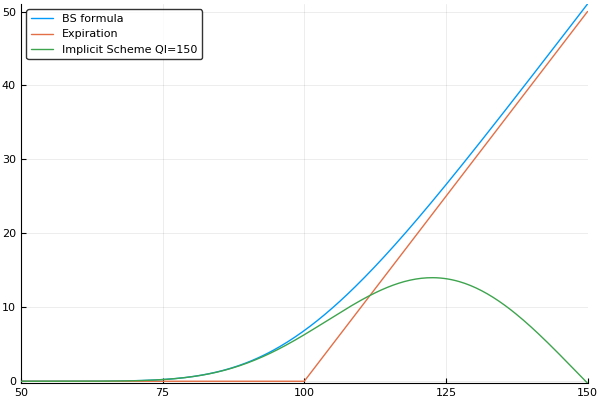

In [4]:
model = BS(QI=150)
plot(model.Qgrid, [BS_price_europeans(model, Q)[1] for Q in model.Qgrid], label="BS formula")
plot!(model.Qgrid, [call(model, Q)[1] for Q in model.Qgrid], label="Expiration")

solve_BS_FTBS(model, call)
@time value = solve_BS_FTBS(model, call)
plot!(model.Qgrid, value, label="Implicit Scheme QI=150")

### 2.2.


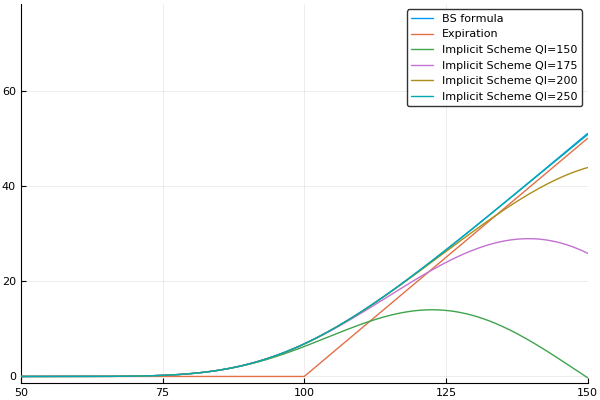

In [5]:
model = BS(QI=175)
plot!(model.Qgrid, solve_BS_FTBS(model, call), label="Implicit Scheme QI=175", xlim=(50, 150))
model = BS(QI=200)
plot!(model.Qgrid, solve_BS_FTBS(model, call), label="Implicit Scheme QI=200")
model = BS(QI=250)
plot!(model.Qgrid, solve_BS_FTBS(model, call), label="Implicit Scheme QI=250")

Looks like $Q_I = 250$ and $I=300$ is fine.

### 2.3.
If $f\Big(\log Q, t\Big) = g\Big(Q,t\Big)$, then $f\Big(q, t\Big) = g\Big(\exp q,t\Big)$ and $f_q\Big(q, t\Big) = g_Q\Big(Q,t\Big)\cdot Q$. 

And $f_q\Big(q, t\Big) = g_Q\Big(\exp q,t\Big)\cdot \exp q$, so $f_{qq}\Big(q, t\Big) = g_{QQ}\Big(Q,t\Big)\cdot Q^2 + g_Q\Big(Q,t\Big)\cdot Q$

$$0=-r \, f(q,t) + f_t(q,t) + f_q(q,t) \, r + \frac{1}{2} \Big( f_{qq}(q,t)-f_q(q,t) \Big) \, \sigma^2$$
Hence:
$$0=-r \, f(q,t) + f_t(q,t) + f_q(q,t) \cdot \Big(r - \frac{1}{2} \sigma^2\Big) + \frac{1}{2} f_{qq}(q,t) \, \sigma^2$$

With an equidistant grid on $q$ this leads to coefficients that are very easily computed and the local variability in $q$ is constant over time.

For interior points:
$$0=-r \, f(i,j) + \frac{f(i,j+1)}{\Delta t} - \frac{f(i,j)}{\Delta t} + \frac{f(i,j)}{\Delta q}\cdot \Big(r - \frac{1}{2} \sigma^2\Big) - \frac{f(i-1,j)}{\Delta q} \cdot \Big(r - \frac{1}{2} \sigma^2\Big) + \frac{\sigma^2}{2} \Big(\frac{f(i+1,j)}{\Delta q^2}-2\frac{f(i,j)}{\Delta q^2} + \frac{f(i-1,j)}{\Delta q^2}\Big)$$

for $i=0$:
$$0=-r \, f(0,j) + \frac{f(0,j+1)}{\Delta t} - \frac{f(0,j)}{\Delta t} + \frac{f(1,j)}{\Delta q}\cdot \Big(r - \frac{1}{2} \sigma^2\Big) - \frac{f(0,j)}{\Delta q} \cdot \Big(r - \frac{1}{2} \sigma^2\Big) + \frac{\sigma^2}{2} \Big(\frac{f(2,j)}{\Delta q^2}-2\frac{f(1,j)}{\Delta q^2} + \frac{f(0,j)}{\Delta q^2}\Big)$$

for $i=I$:
$$0=-r \, f(I,j) + \frac{f(I,j+1)}{\Delta t} - \frac{f(I,j)}{\Delta t} + \frac{f(I,j)}{\Delta q}\cdot \Big(r - \frac{1}{2} \sigma^2\Big) - \frac{f(I-1,j)}{\Delta q} \cdot \Big(r - \frac{1}{2} \sigma^2\Big) + \frac{\sigma^2}{2} \Big(\frac{f(I,j)}{\Delta q^2}-2\frac{f(I-1,j)}{\Delta q^2} + \frac{f(I-2,j)}{\Delta q^2}\Big)$$

### 2.4.
I have to increase $I$ to $400$ to get good results:


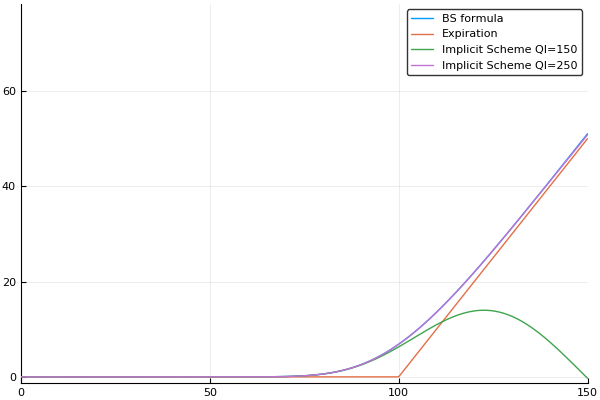

In [6]:
model = BS(Q0=0.01, QI=150, I=400)
plot(model.Qgrid, [BS_price_europeans(model, Q)[1] for Q in model.Qgrid], label="BS formula")
plot!(model.Qgrid, [call(model, Q)[1] for Q in model.Qgrid], label="Expiration")

plot!(model.Qgrid, solve_BS_FTBS(model, call), label="Implicit Scheme QI=150", xlim=(0,150))
model = BS(Q0=0.01, QI=250, I=400)
plot!(model.Qgrid, solve_BS_FTBS(model, call), label="Implicit Scheme QI=250")

In [7]:
@with_kw mutable struct BS_Log
    T::Float64            # t ∈ [0, T]
    J::Int64            # t ∈ [t0, tJ]
    Δt::Float64           # step size
    Tgrid::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}        # J + 1 grid

    q0::Float64           # lower bound
    qI::Float64           # upper bound
    I::Int64            # Q ∈ [Q0, QI]
    Δq::Float64
    qgrid::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}        # I + 1 grid

    σ::Float64
    r::Float64
    K::Float64
end

function BS_Log(; T = 1., J = 500, q0 = log(0.01), qI = log(150), I = 500, σ = 0.16, r = 0.01, K = 100.)
    BS_Log(T, J, T/J, linspace(0,T,J+1), q0, qI, I, (qI-q0)/I, linspace(q0, qI, I+1), σ, r, K)
end

function call(model::BS_Log, q)
    max.(exp.(q) .- model.K, 0)
end

call (generic function with 2 methods)

In [8]:
function solve_BS_Log_FTBS(logmodel::BS_Log, G::Vector{Float64})
    @unpack T, J, Δt, Tgrid, q0, qI, I, Δq, qgrid, σ, r, K = logmodel
    g = zeros(I+1)
    g = G
    
    A = spzeros(I+1, I+1)

    for j in J:-1:1
        A = spzeros(I+1, I+1)

        A[1, 1:3] = [r + 1/Δt + (r-1/2*σ^2)/Δq - σ^2 / (2 * Δq^2), -(r-1/2*σ^2)/Δq + σ^2 / Δq^2, -σ^2 / (2 * Δq^2)]

        for i = 2:I
            A[i, (i-1):(i+1)] = [(r-1/2*σ^2)/Δq - σ^2/(2 * Δq^2), r + 1/Δt - (r-1/2*σ^2)/Δq + σ^2 / Δq^2, -σ^2 / (2 * Δq^2)]
        end

        A[I+1, (I-1):(I+1)] = [-σ^2 / (2 * Δq^2), (r-1/2*σ^2)/Δq + σ^2 / Δq^2, r + 1/Δt - (r-1/2*σ^2)/Δq - σ^2 / (2 * Δq^2)]

        g = (A \ (g ./ Δt))::Vector{Float64}
    end
    
    return g[:,1]
end

solve_BS_Log_FTBS (generic function with 1 method)

  2.779657 seconds (6.31 M allocations: 4.509 GiB, 20.51% gc time)



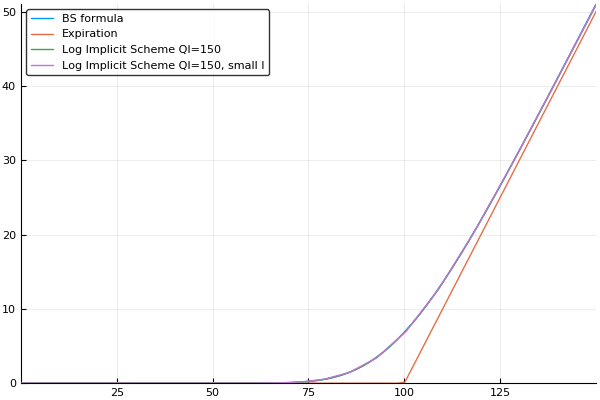

In [9]:
logmodel = BS_Log()
plot(exp.(logmodel.qgrid), [BS_price_europeans(model, Q)[1] for Q in exp.(logmodel.qgrid)], label="BS formula")
plot!(exp.(logmodel.qgrid), [call(model, Q)[1] for Q in exp.(logmodel.qgrid)], label="Expiration")

solve_BS_Log_FTBS(logmodel, call(logmodel, logmodel.qgrid))
@time value = solve_BS_Log_FTBS(logmodel, call(logmodel, logmodel.qgrid))
plot!(exp.(logmodel.qgrid), value, label="Log Implicit Scheme QI=150")

logmodel = BS_Log(I=120)
plot!(exp.(logmodel.qgrid), solve_BS_Log_FTBS(logmodel, call(logmodel, logmodel.qgrid)), label="Log Implicit Scheme QI=150, small I")

Even with a very small $I$ the solution is still good!

## Experimental:

An explicit scheme would be:
$$r\,g(i,j) = \frac{g(i,j)-g(i,j-1)}{\Delta t} + g_Q(i,j)\,r\,Q_i + \frac{1}{2}\,g_{QQ}(i,j)\,\sigma^2\,Q_i^2$$
$$g(i,j)-\Delta t\cdot\Big(r\,g(i,j) - g_Q(i,j)\,r\,Q_i - \frac{1}{2}\,g_{QQ}(i,j)\,\sigma^2\,Q_i^2\Big) = g(i,j-1)$$

In [10]:
function backward_difference(g, Q)
    vcat((g[2] - g[1]) ./ (Q[2] - Q[1]), (g[2:(end)] - g[1:(end-1)]) ./ (Q[2:(end)] - Q[1:(end-1)])) 
end

function forward_difference(g, Q)
    vcat((g[2:(end)] - g[1:(end-1)]) ./ (Q[2:(end)] - Q[1:(end-1)]), (g[end] - g[end-1]) ./ (Q[end] - Q[end-1])) 
end

forward_difference (generic function with 1 method)


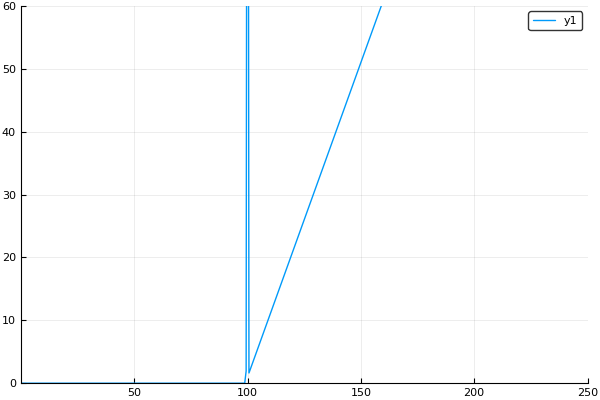

In [11]:
@unpack T, J, Δt, Tgrid, Q0, QI, I, Qgrid, σ, r, K = model
g = zeros(I+1, J+1)
g[:, J+1] = call(model, Qgrid)

for j in J:-1:1
    gQ = backward_difference(g[:, J+1], Qgrid)
    gQQ = forward_difference(gQ, Qgrid)
    g[:, j] = g[:, j+1] .- Δt * (r * g[:, j+1] - r * gQ .* Qgrid - 1/2 * σ^2 * gQQ .* (Qgrid.^2))
end

plot(Qgrid, g[:, 1], ylim=(0, 60))

Does not look good at the kink!